## Парсер и анализатор чатов WhatsApp
### Данные предоставляются через экспорт чата в меню приложения.
По основному своему функционалу этот код предназначен для анализа чатов-групп с 3 и более участниками. Будет работать и с обычными переписками из двух человек, но тогда некоторые аспекты просто теряют свою необходимость (типа коэффициентов корреляции между участниками).
Помогает узнать как очевидные вещи, так и вполне неожиданные.
Анализирует текст на наличие матерных слов и считает статистику использования мата. Что характерно, по причине того, что поиск идёт по корневым словам, то даже в самых невинных чатах можно найти мат (типа застраХУЙ или МАНДАрин).
Датасет можно получить из приложения в меню чата:

1. Три точечки в верхнем-правом углу
![](images/1.png)

2. Раздел More (в Руссокой локали "Ещё")
![](images/2.png)

3. Выбрать "Export chat" (Экспорт чата")
![](images/3.png)

4. Экспортировать чат без мультимедиа. Нам не нужны картинки с котятами и фотографии майонеза.
![](images/4.png)

Начнём с импорта библиотек и открытие/чтения файлов.

swears.txt - словарь матерных слов.

так-же задаём кое-какие глобальные переменные:
'''swears_dict''' - сюда будем собирать матерный лексикон со всего чата, во что горазды авторы
'''words_dict''' - сюда будем собирать общий словарный запас всего чата.
все словари с счётчиками использования данного слова в качестве значения ключа - слова.

'''plt.style.use('ggplot')''' - красивое оформление для графиков :+1:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import pandas as pd
import re
import glob

### opening swears dictionary and log dataset
swears = open('dataset/swears.txt', 'r', encoding="utf-8")
swears = swears.read()
swears = swears.split('\n')

f = open(glob.glob('dataset/*WhatsApp*.txt')[0], 'r', encoding="utf-8")
f = f.read()
f = f.replace('\n', ' ')

### initializing global variables
swears_dict = {}
words_dict = {}
plt.style.use('ggplot')


Потом задаём несколько функций, который помогут в дальнем векторном агрегировании данных масива.
Счётчик слов
Счётчик только матерных слов
Сборщик библиотеки мата
Сборщик общего словарного запаса

In [2]:
def words_count(string):
	### function returns the number of words in string
	if (string[0] != '<' and string[-1] != '>'):
		return len(string.split())

def swear_count(string):
	### function returns the number of swear words found in input string
	string = string.lower()
	count = 0
	for word in swears:
		count += string.count(word)		
	return count

def swears_collect(string):
	### function for adding swear words to global swear_dict dictionary from input string
	string = string.lower().split()
	for word in string:
		for swear in swears:
			if swear in word:
				if word in swears_dict:
					swears_dict[word] += 1
				else:
					swears_dict[word] = 1
	
def to_dict(string):
	### fucntion for adding all words from input string to global words_dict dictionary
	string = string.lower()
	if (string[0] != '<' and string[-1] != '>'):
		string = string.split()
		for word in string:	
			if (word in words_dict and len(word) > 3):
				words_dict[word] += 1
			else:
				words_dict[word] = 1

Прогоняем наш файл с чатом через парсер. Регулярным выражением выуживаем паттерны сообщений со структурой даты/автора/текста.
Пропускаем сервисные сообщения.
Печатем первые 5 строк датасета.

In [3]:
##### Parcing the raw dataset, cleaning it.
pattern = re.compile(r'(?P<timestamp>\d\d.\d\d.\d\d\d\d, \d\d:\d\d) - (?!\u200e)(?P<author>.*?): (?P<text>.*?)(?=( \d\d.\d\d.\d\d\d\d, \d\d:\d\d| $))')
match = re.findall(pattern, f)

df = pd.DataFrame.from_dict(match)
df = df.iloc[1:, 0:3]
df.columns=['timestamp', 'author', 'text']
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d.%m.%Y, %H:%M')
df.set_index('timestamp', inplace=True)

print(df.head())

                             author      text
timestamp                                    
2018-12-31 14:06:00  Миша Колобегов     Давай
2018-12-31 14:06:00    Anton Petkov  Ох ебать
2018-12-31 14:06:00    Anton Petkov   Здарова
2018-12-31 14:06:00  Миша Колобегов     Антик
2018-12-31 14:06:00   Леха Харченко   Здарова


Добавляем вспомогательные колонки. Добовляем не без помощи заранее прописаных функций.
swears_num - колтчество матерных слов в сообщении
words_num - количество слов в сообщении
media - тип сообщения (медиа или текст)
hour - час в течении которого было оставлено сообщение

In [4]:
#### ADDING COLUMNS

### adding column with swears number in each message
df['swears_num'] = df['text'].map(swear_count)
# df.sort_values('swears_num', inplace=True)

### adding column with all words in message number
df['words_num'] = df['text'].map(words_count)

### adding column with boolean whether the message is just a meme or video
df['media'] = df['text'].map(lambda x: 'Media' if (x[0] == '<' and x[-1] == '>') else 'Text')

### adding 'hour' column for further grouping
df['hour'] = df.index.hour

Общее число сообщений:

In [5]:
### printing the number of messages
authors_num = df.shape[0]
print('Overall number of messages: {}'.format(authors_num))

Overall number of messages: 7538


Количество и список участников (тут везде "авторов") чата:

In [8]:
### building the list of authors, printing it
authors = df['author'].unique().tolist()
print('There are {} authors in chat: \n{}'.format(len(authors), authors))

There are 8 authors in chat: 
['Миша Колобегов', 'Anton Petkov', 'Леха Харченко', 'Витек', 'Сева Баянович', 'Эдик Лыскунов', 'Стас Джулай', '+7 904 344-74-40']


Дата самого первого сообщения (создание чата), последнего сообщения, возраст чата:

In [9]:
### printing first message, last message, chat age
print('First message date: {}'.format(min(df.index)))
print('Last message date: {}'.format(max(df.index)))
days = int((max(df.index) - min(df.index)).days)
print('Chat age in days: {}\nChat age in years: {:.2f}'.format(days, days / 365))
avg_msg_hour = df.groupby('hour').count()['text'] / days

First message date: 2018-12-31 14:06:00
Last message date: 2019-09-29 19:03:00
Chat age in days: 272
Chat age in years: 0.75


Составляем словари слов и матерных слов:

In [10]:
### buildig a dict (words_dict) with words from chat (text column). Not adding a column, but collecting data
df['text'].map(to_dict)
words_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)

### building a dict of swears usage (swears_dict) from words_dict. Not adding a column, but collecting data
df['text'].map(swears_collect)
swears_dict = sorted(swears_dict.items(), key=lambda x: x[1], reverse=True)

Плодим ещё один фрейм (точнее Series) (что конечно зря, ну да ладно) с количеством сообщений в неделю за весь период чата:

In [12]:
### calculating weekly messages number for alltime
msg_weekly = df.resample('W').count()['text']

Рассчитываем процент мата у каждого участника чата:
Первый фрейм со столбцами "Общее кол-во слов" - "Из них мата"
Второй топ по процентным соотношениям, самые матершинники вверху.

In [13]:
### calculating swear words usage for each author
words_swears_users = df.groupby('author').sum()[['words_num', 'swears_num']]
print(words_swears_users.head())
words_swears_users['percent'] = (words_swears_users['swears_num'] / words_swears_users['words_num']) * 100
words_swears_users = words_swears_users.sort_values(by='percent', ascending=False)
print('\nWords vs. swears percent per author:')
print(words_swears_users['percent'].head())

                  words_num  swears_num
author                                 
+7 904 344-74-40       27.0           0
Anton Petkov         4467.0         133
Витек                8115.0         224
Леха Харченко        1049.0          34
Миша Колобегов       6216.0          45

Words vs. swears percent per author:
author
Леха Харченко    3.241182
Anton Petkov     2.977390
Витек            2.760320
Сева Баянович    1.831502
Эдик Лыскунов    0.776119
Name: percent, dtype: float64


Рассчёт матрицы корреляций Пирсона для каждого участника автора, с дальнейшей сортировкой наивысших коэффициентов наверх:
В данном случае коэффициент - по сути вероятность того, что участники общаются между собой, чем между другими участниками.

In [14]:
### calculating the pearsons correlation matrix for each pair of authors, fetching the best of them
corr_matrix = df.groupby(['hour', 'author']).count()['text']
print('\n')
corr_matrix = corr_matrix.unstack(level=-1, fill_value=0)
corr_matrix = corr_matrix.corr()
corr_matrix.replace(to_replace=1, value=0, inplace=True)
corr_matrix = corr_matrix.stack().sort_values(ascending=False).drop_duplicates()
print('Top authors with messages timing correlation:')
print(corr_matrix.head())



Top authors with messages timing correlation:
author          author        
Миша Колобегов  Витек             0.840906
Anton Petkov    Эдик Лыскунов     0.828766
Витек           Леха Харченко     0.807938
Леха Харченко   Миша Колобегов    0.772735
Сева Баянович   Леха Харченко     0.731589
dtype: float64


Время рисунков!
Первый график - общее количество сообщений у каждого участника.
При большом количестве участников (больше 10) - выводит только первые 10, предварительно отсортировав самых активных наверх. А то получится неразборчивая каша.

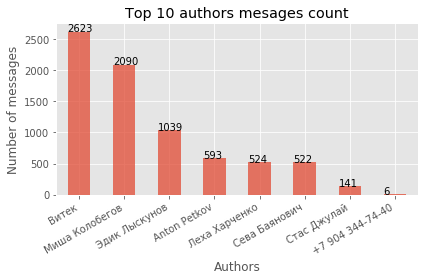

In [18]:
##### PLOTTING PART
### plots media/text percentage

### calculating and plotting overall authors messages number
authors_count = df.groupby(['author']).count()['text']
authors_count = authors_count.sort_values(ascending=False)
if authors_num > 10:
	title = 'Top 10 authors mesages count'
	authors_count = authors_count.iloc[:10]
else:
	title = 'Authors messages count'
ax = authors_count.plot(kind='bar', title=title, alpha=0.75)
ax.set_ylabel('Number of messages')
ax.set_xlabel('Authors')
for i in ax.patches:
	ax.text(i.get_x(), i.get_height(), str(int(i.get_height())))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') # rotating long xticks and make them confy to read
plt.tight_layout()
plt.show()

График (а еще и топ-5) публикации текстовых сообщений/медиа участниками. Видны предпочтения авторов, кто любит писать, а кто картинки слать.

media           Media    Text
author                       
Витек           630.0  1993.0
Миша Колобегов  503.0  1587.0
Эдик Лыскунов   169.0   870.0
Anton Petkov     93.0   500.0
Сева Баянович   133.0   389.0


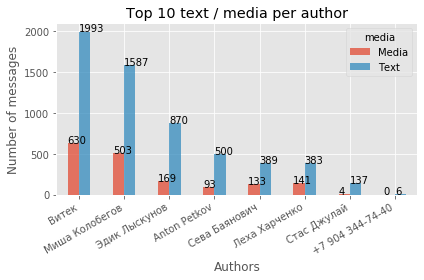

In [19]:
### calculating media/text ratio per author and plotting it
medias_per_capita = df.groupby(['author', 'media']).count()['text']
medias_per_capita = medias_per_capita.unstack(level=1)
medias_per_capita = medias_per_capita.sort_values(by='Text', ascending=False)
if authors_num > 10:
	medias_per_capita = medias_per_capita.iloc[:10, :]
	title = 'Top 10 text / media per author'
else:
	title = 'Text / Media per author'	

print(medias_per_capita.head())

ax = medias_per_capita.plot(kind='bar', title=title, alpha=0.75)
ax.set_ylabel('Number of messages')
ax.set_xlabel('Authors')
for i in ax.patches:
	ax.text(i.get_x(), i.get_height(), str(int(i.get_height())))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') # rotating long xticks and make them confy to read
plt.tight_layout()
plt.show()

График общей активности чата за всю историю:
новый год так сразу видно)))

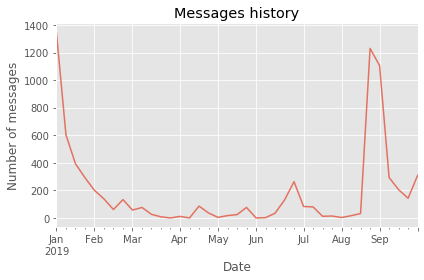

In [20]:
### plotting overall messages history
msg_weekly.plot(kind='line', title='Messages history', alpha=0.75)
plt.xlabel('Date')
plt.ylabel('Number of messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

График использования картинок/мемасов/котят/еды вместо текста:

media
Media    1673
Text     5865
Name: text, dtype: int64


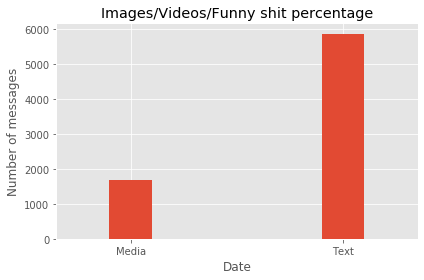

In [21]:
medias = df.groupby(['media']).count()['text']
print(medias)
medias.plot(kind='bar', title='Images/Videos/Funny shit percentage', width=0.20)
plt.xlabel('Date')
plt.ylabel('Number of messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

График среднего количества сообщений в определённый час суток:
Задавать свои вопросы с вероятностью быстро получить ответ лучше именно в пиковые его значения.

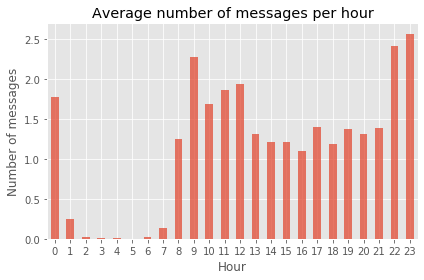

In [22]:
avg_msg_hour.plot(kind='bar', title='Average number of messages per hour', alpha=0.75, )
plt.xlabel('Hour')
plt.ylabel('Number of messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Топ 20 слов используемых в чате: Ограничил размер от 3 символов, ибо предлоги всегда в топе использования в человеческой речи.
И топ 20 матерных слов в чате:
В списке (слово, его количество)

In [24]:
print('Top 20 chart of words used in chat, longer then 3 characters: \n', words_dict[:20])
print('\n')
print('Top 20 chart of swear words: \n', swears_dict[:20])

Top 20 chart of words used in chat, longer then 3 characters: 
 [('брат', 145), ('😂😂😂😂', 81), ('меня', 77), ('только', 74), ('тоже', 74), ('надо', 71), ('новая', 70), ('когда', 65), ('ебать', 64), ('есть', 59), ('просто', 58), ('если', 58), ('пиздец', 53), ('было', 52), ('потом', 49), ('тебя', 49), ('сейчас', 46), ('брат,', 44), ('помню', 44), ('братан', 43)]


Top 20 chart of swear words: 
 [('ебать', 64), ('пиздец', 53), ('хуй', 30), ('пизда', 22), ('нахуй', 21), ('хуйня', 12), ('ахуел', 10), ('ахуеть', 10), ('похуй', 10), ('ебать,', 9), ('пиздец.', 9), ('пиздос', 6), ('хуйню', 6), ('нехуй', 5), ('ахуе', 5), ('ахуенный', 5), ('пизды', 5), ('хуету', 5), ('ахуенно', 5), ('ебаные', 5)]
